In [3]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import kagglehub
import io
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:

def load_mnist_data():
    data_dir = "/kaggle/input/double-mnist/double_mnist"
    splits = ['train', 'val', 'test']
    data = {}

    for split in splits:
        images = []
        labels = []
        split_dir = os.path.join(data_dir, split)

        for folder_name in os.listdir(split_dir):
            folder_path = os.path.join(split_dir, folder_name)
            if not os.path.isdir(folder_path):
                continue

            # Label is the number of digits in the folder name
            label = len(folder_name)

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (28, 28))
                images.append(img)
                labels.append(label)

        data[f"{split}_images"] = np.array(images, dtype=np.float32)
        data[f"{split}_labels"] = np.array(labels, dtype=np.int64)

    return data['train_images'], data['train_labels'], data['val_images'], data['val_labels'], data['test_images'], data['test_labels']

In [14]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image / 255.0

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [15]:
data_dir = "/content/double_mnist/"

train_images, train_labels, val_images, val_labels, test_images, test_labels = load_mnist_data()

train_dataset = MultiMNISTDataset(train_images, train_labels)
val_dataset = MultiMNISTDataset(val_images, val_labels)
test_dataset = MultiMNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, conv_layers=[32, 64], kernel_size=3, stride=1, dropout_rate=0.5, padding=0, task="classification"):
        super(CNN, self).__init__()
        assert task in ["classification", "regression"], "Task must be 'classification' or 'regression'"
        
        self.task = task
        self.conv_layers = conv_layers  # Layers configuration

        # Initialize convolutional layers with batch normalization
        self.convs = nn.ModuleList()
        in_channels = 1  # Input channels (1 for grayscale images)
        for out_channels in conv_layers:
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
            self.convs.append(nn.BatchNorm2d(out_channels))  # Add BatchNorm
            in_channels = out_channels  
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        self._initialize_fc_in_features()

        # Define fully connected layers
        self.fc1 = nn.Linear(self.in_features, 128)
        self.fc2 = nn.Linear(128, 1 if task == "regression" else 10)

    def _initialize_fc_in_features(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)  # Assuming input size is 28x28 with 1 channel
            x = dummy_input
            for layer in self.convs:
                x = layer(x) if isinstance(layer, nn.Conv2d) else x  # Apply only Conv2d and BatchNorm layers
                if isinstance(layer, nn.BatchNorm2d):
                    x = F.relu(x)  # Apply ReLU after BatchNorm
                if isinstance(layer, nn.MaxPool2d):
                    x = self.pool(x)
            self.in_features = x.numel()
            

    def forward(self, x):
        feature_maps = []
        # Pass through convolutional layers
        for layer in self.convs:
            x = layer(x)  # Apply Conv2d, BatchNorm, and MaxPool
            if isinstance(layer, nn.Conv2d):
                feature_maps.append(x)  # Capture feature map after convolution
            if isinstance(layer, nn.BatchNorm2d):
                x = F.relu(x)  # Apply ReLU after BatchNorm
                feature_maps.append(x)  # Capture feature map after ReLU
            if isinstance(layer, nn.MaxPool2d):
                x = self.pool(x)
                feature_maps.append(x)  # Capture feature map after pooling

        # Flatten the output from conv layers
        x = x.view(-1, self.in_features)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Output layer
        if self.task == "classification":
            x = self.fc2(x)
            return F.log_softmax(x, dim=1), feature_maps
        else:
            x = self.fc2(x)
            return x, feature_maps

In [21]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
import torch

def train_model(model, train_loader, criterion, optimizer, task_type, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs,_ = model(images)
        if task_type=="regression":
            outputs = outputs.squeeze(-1)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track loss and predictions
        running_loss += loss.item()
        
        if task_type == 'classification':
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        elif task_type == 'regression':
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.detach().cpu().numpy())
    
    # Calculate average loss
    avg_loss = running_loss / len(train_loader)
    
    # Calculate metric based on task type
    if task_type == 'classification':
        metric = accuracy_score(all_labels, all_preds)
    elif task_type == 'regression':
        metric = mean_squared_error(all_labels, all_preds)  # or use mean_absolute_error

    return avg_loss, metric

def evaluate_model(model, val_loader, criterion, task_type, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs,_ = model(images)
            if task_type=="regression":
                outputs = outputs.squeeze(-1)
        
            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Track predictions
            if task_type == 'classification':
                _, predicted = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
            elif task_type == 'regression':
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(outputs.detach().cpu().numpy())
    
    # Calculate average loss
    avg_loss = running_loss / len(val_loader)
    
    # Calculate metric based on task type
    if task_type == 'classification':
        metric = accuracy_score(all_labels, all_preds)
    elif task_type == 'regression':
        metric = mean_squared_error(all_labels, all_preds)  # or use mean_absolute_error
    
    return avg_loss, metric


In [9]:
import wandb
import torch.optim as optim
import torch.nn as nn

def hyperparam_tuning_classification(train_loader, val_loader, device='cpu'):
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'learning_rate': {
                'values': [0.01, 0.1]
            },
            'dropout_rate': {
                'values': [0.25, 0.5]
            },
            'epochs': {
                'values': [10, 100]
            },
            'optimizer': {
                'values': ['adam', 'sgd']
            },
            'conv_configs': {
                'values': [
                          [32, 64],             # Two layers
                          [32, 64, 128],        # Three layers
                          ]
            },
            'task': {
                'values': ['classification']
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project="CNN-Hyperparameter-Tuning-kaggle")

    def train_and_evaluate():
        wandb.init()
        config = wandb.config
        print(f"Running with config: {config}")
        wandb.run.name = f"task={config['task']}-optimizer={config['optimizer']}-lr={config['learning_rate']}-epochs={config['epochs']}-dropout={config['dropout_rate']}"
        
        model = CNN(task=config['task'], dropout_rate=config['dropout_rate'], conv_layers=config['conv_configs']).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate']) if config['optimizer'] == 'adam' else optim.SGD(model.parameters(), lr=config['learning_rate'])

        criterion = nn.CrossEntropyLoss()

        train_losses, val_losses, val_metrics = [], [], []
        
        for epoch in range(config['epochs']):
            train_loss, train_metric = train_model(model, train_loader, criterion, optimizer, config['task'], device=device)
            train_losses.append(train_loss)

            val_loss, val_metric = evaluate_model(model, val_loader, criterion, config['task'], device=device)
            val_losses.append(val_loss)
            val_metrics.append(val_metric)

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_accuracy": val_metric
            })
        wandb.finish()
        
    wandb.agent(sweep_id, function=train_and_evaluate)


def hyperparam_tuning_regression(train_loader, val_loader, device='cpu'):
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'val_mse',
            'goal': 'minimize'
        },
        'parameters': {
            'learning_rate': {
                'values': [0.01, 0.1]
            },
            'dropout_rate': {
                'values': [0.25, 0.5]
            },
            'epochs': {
                'values': [10, 100]
            },
            'optimizer': {
                'values': ['adam', 'sgd']
            },
            'conv_configs': {
                'values': [
                          [32, 64],             # Two layers
                          [32, 64, 128],        # Three layers
                          ]  
            },
            'task': {
                'values': ['regression']
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project="CNN-Hyperparam-Tuning-kaggle-regression")

    def train_and_evaluate():
        wandb.init()
        config = wandb.config
        print(f"Running with config: {config}")
        wandb.run.name = f"task={config['task']}-optimizer={config['optimizer']}-lr={config['learning_rate']}-epochs={config['epochs']}-dropout={config['dropout_rate']}"
        
        model = CNN(task=config['task'], dropout_rate=config['dropout_rate'], conv_layers=config['conv_configs']).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate']) if config['optimizer'] == 'adam' else optim.SGD(model.parameters(), lr=config['learning_rate'])

        criterion = nn.MSELoss()

        train_losses, val_losses, val_metrics = [], [], []
        
        for epoch in range(config['epochs']):
            train_loss, train_metric = train_model(model, train_loader, criterion, optimizer, config['task'], device=device)
            train_losses.append(train_loss)

            val_loss, val_metric = evaluate_model(model, val_loader, criterion, config['task'], device=device)
            val_losses.append(val_loss)
            val_metrics.append(val_metric)

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_mse": val_metric
            })
        wandb.finish()
        
    wandb.agent(sweep_id, function=train_and_evaluate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [44]:
hyperparam_tuning_regression(train_loader, val_loader, device=device)

wandb: Agent Starting Run: fgf2wbht with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: regression


Create sweep with ID: s30jd3xv
Sweep URL: https://wandb.ai/vcnk4v/CNN-Hyperparam-Tuning-kaggle-regression/sweeps/s30jd3xv
wandb: 🚀 View run polar-sweep-2 at: https://wandb.ai/vcnk4v/CNN-Hyperparam-Tuning-kaggle-regression/runs/w2m4qlxt
wandb: Find logs at: wandb/run-20241102_202345-w2m4qlxt/logs


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,▁▆██▃▁▁▃▁▁
val_mse,▁▆██▃▁▁▃▁▁
epoch,10
train_loss,0.49718
val_loss,0.46381
val_mse,0.46436


wandb: Agent Starting Run: nbqvelg3 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁
val_mse,█▃▂▂▂▂▁▁▁▁
epoch,10
train_loss,0.10605
val_loss,0.0746
val_mse,0.07457


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sevutm91 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▇▄▄█▆▄▄▅▁▃
val_mse,▇▄▄█▆▄▄▅▁▃
epoch,10
train_loss,0.66235
val_loss,0.47461
val_mse,0.47509


wandb: Agent Starting Run: 7gualb1o with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▆▁▁
val_mse,█▄▄▃▃▂▂▆▁▁
epoch,10
train_loss,0.02763
val_loss,0.01359
val_mse,0.01361


wandb: Agent Starting Run: 17a7jlq8 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▆▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▂▂▂▁▁▂▂▂▁▂▁▁▂▂▁▂▄▂▁▁▁▁▂
val_loss,▆█▂▃▂▁▁▁▂▁▂▁▂▁▁▄▁▁▁▁▂▁▂▂▃▁▂▂▁▁▁▃▁▂▁▁▂▃▂▁
val_mse,▇▆▃▄▂▃▂▂▂▃▂▂▄▂▂█▁▂▃▁▁▂▃▄▃▂▂▃▄▂▂▁▄▂▅▂▃▂▁▂
epoch,100
train_loss,0.03808
val_loss,0.02022
val_mse,0.02023


wandb: Agent Starting Run: jkhb981u with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
train_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▇▆▅▅▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.01462
val_loss,0.00977
val_mse,0.00979


wandb: Agent Starting Run: y9y7e1wc with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▁█▄▁▁▃▆▁▁▃▂▁▂▁▃▂▁▂▁▁▂▁▁▂▃▃▄▁▇▁▂▄▃▃▃▁▂▁
val_mse,█▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.49501
val_loss,0.46317
val_mse,0.46373


wandb: Agent Starting Run: wyfig1wd with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▄▄▃▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▆█▅▄▃▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁
epoch,100
train_loss,0.00946
val_loss,0.00565
val_mse,0.00566


wandb: Agent Starting Run: s158pew1 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▆▇▇▃▂▁▁▁▁
val_mse,█▆▇▇▃▂▁▁▁▁
epoch,10
train_loss,0.06102
val_loss,0.02979
val_mse,0.02983


wandb: Agent Starting Run: 9klolruh with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▂▂▂▁▁▁▁▁
val_loss,█▂▂▁▂▁▁▁▁▁
val_mse,█▂▂▁▂▁▁▁▁▁
epoch,10
train_loss,0.11832
val_loss,0.07432
val_mse,0.0743


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zjmdy28h with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▃▆▄█▇▁▂▁▅▁
val_mse,▃▆▄█▇▁▂▁▅▁
epoch,10
train_loss,0.54425
val_loss,0.46822
val_mse,0.46874


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2au6kmyq with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▁▁▁▁▁
val_mse,█▅▃▃▂▁▁▁▁▁
epoch,10
train_loss,0.0446
val_loss,0.02709
val_mse,0.02714


wandb: Agent Starting Run: 2fo5402y with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▇▅▃▃▃▃▃▃▃▃▃▃▂▄▃▃▃▃▃▂▂▃▃▃▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁
val_loss,█▄▃▃▃▂▂▃▄▇▂▂▄▂▂▂▂▂▁▁▂▂▃▂▂▅▂▃▃▁▃▁▃▃▁▂▂▄▁▄
val_mse,█▇▄▄▃▃▂▂▃▂▃▇▃▂▂▂▂▂▂▂▁▂▂▂▂▃▃▂▃▁▁▁▁▃▁▁▂▂▁▂
epoch,100
train_loss,0.05549
val_loss,0.02242
val_mse,0.02243


wandb: Agent Starting Run: yirkqzxo with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
train_loss,█▇▇▆▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▇▇▇▆▆▅▄▅▄▃▃▂▂▃▂▂▂▂▅▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.02432
val_loss,0.01217
val_mse,0.01219


wandb: Agent Starting Run: d7mew5l4 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_loss,█▆▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▅▅▁▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▂
val_mse,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▂▁▂▁▁
epoch,100
train_loss,0.4951
val_loss,0.46247
val_mse,0.46304


wandb: Agent Starting Run: bsk0m2ci with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▂▂▂▃▂▂▂▃▂▂▁▂▂▂▁▃▁▁▂▁▁▁▃▂▁▁▁▁▁▂▁▁▃▁▄
val_mse,█▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.0166
val_loss,0.00629
val_mse,0.0063


wandb: Agent Starting Run: g649ctao with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▁▁▁▁▁▁
val_loss,█▄▄▂▃▃▂▃▁▂
val_mse,█▄▄▂▃▃▂▃▁▂
epoch,10
train_loss,0.1609
val_loss,0.16446
val_mse,0.16466


wandb: Agent Starting Run: tv8ok27h with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▇▅▄▃▂▂▁▁▁
val_mse,█▇▅▄▃▂▂▁▁▁
epoch,10
train_loss,0.24259
val_loss,0.19965
val_mse,0.19971


wandb: Agent Starting Run: fkk4rhhy with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁█▂▃▁▁
val_mse,▁▁▁▁▁█▂▃▁▁
epoch,10
train_loss,0.7347
val_loss,0.47455
val_mse,0.47503


wandb: Agent Starting Run: jiltvns4 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▁▁▁▁▁
val_loss,█▅█▃▃▂▄▂▁▁
val_mse,█▅█▃▃▂▄▂▁▁
epoch,10
train_loss,0.15309
val_loss,0.14537
val_mse,0.14561


wandb: Agent Starting Run: 2vt7v9d5 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,█▆▂▂▂▂▃▂▂▂▂▁▁▂▂▁▂▃▂▁▂▁▂▂▁▂▁▁▁▂▁▂▁▁▂▁▁▂▁▁
val_mse,█▅▃▄▄▂▅▃▂▁▃█▃▁▁▃▁▂▄▁▁▂▂▃▁▁▃▅▂▂▂▄▄▃▄▂▃▂▂▂
epoch,100
train_loss,0.1533
val_loss,0.14898
val_mse,0.1492


wandb: Agent Starting Run: i9j1hbq8 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mse,█▅▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▂▁
epoch,100
train_loss,0.1297
val_loss,0.14333
val_mse,0.14352


wandb: Agent Starting Run: dut5pgj2 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▇▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▇▅█▂▂▁▂▁▁▁▁▂▂▁▂▂█▂▁▂▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▃▄▃▃▃
val_mse,█▆▂▂▁▁▁▂▁▂▁▂▁▂▂▂▂▂▂▂▃▃▂▂▂▃▃▃▂▃▄▃▄▃▃▃▄▃▃▃
epoch,100
train_loss,0.05006
val_loss,0.1777
val_mse,0.17795


wandb: Agent Starting Run: mrfb0vea with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▁▁▁▁▁▁▁
val_loss,█▄▃▁▁▂▁▁▁▁
val_mse,█▄▃▁▁▂▁▁▁▁
epoch,10
train_loss,0.19262
val_loss,0.1619
val_mse,0.16212


wandb: Agent Starting Run: qt9bu7rg with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▇▅▄▃▂▂▂▁▁
val_mse,█▇▅▄▃▂▂▂▁▁
epoch,10
train_loss,0.24598
val_loss,0.19677
val_mse,0.19687


wandb: Agent Starting Run: r9r3ejxq with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▃█▃▁▄▅▂▅▃▂
val_mse,▃█▃▁▄▅▂▅▃▂
epoch,10
train_loss,0.82931
val_loss,0.49255
val_mse,0.49296


wandb: Agent Starting Run: bn94rbgy with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▂▁▂
val_mse,█▃▂▂▂▁▁▂▁▂
epoch,10
train_loss,0.16021
val_loss,0.16151
val_mse,0.1617


wandb: Agent Starting Run: k32dvzjr with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇███
train_loss,█▅▅▅▄▅▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▂▁▂▁▁▁▁▁▁▂▂▁▁▂▂▁▂▁▂▂▄▂▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▃
val_mse,█▃▂▂▂▁▂▁▁▁▂▁▂▁▁▁▂▂▂▁▂▂▂▁▂▂▂▂▂▃▂▂▂▃▂▁▂▂▄▃
epoch,100
train_loss,0.1316
val_loss,0.19435
val_mse,0.19459


wandb: Agent Starting Run: hsowpnti with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mse,█▆▄▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁
epoch,100
train_loss,0.13154
val_loss,0.14447
val_mse,0.14467


wandb: Agent Starting Run: kfr7w3m9 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'regression'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▆▆█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.49657
val_loss,0.46184
val_mse,0.46243


wandb: Agent Starting Run: av5ix1zb with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: regression


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'regression'}


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train_loss,█▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▃█▄▁▇▁▁▂▃▂▃▁▂▃▃▃▃▃▅▅▅▄▄▅▅▅▇▅▄▆█▄▇▆█▇▆▇▇▆
val_mse,▅▂▁▂▁▂▃▄▃▁▂▂▂▃▂▃▂▃▃▅▅▅▄▆▄▇▅▅▄▆▆▆▇█▆▆▅▇▆▅
epoch,100
train_loss,0.05933
val_loss,0.17326
val_mse,0.17355


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [13]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error

# Configurations
config = {
    "task": "regression",
    "lr": 0.01,
    "dp": 0.25,
    "epochs": 10,
    "optimizer": "sgd"
}

# Instantiate model, criterion, and optimizer
model = CNN(conv_layers=[32, 64], kernel_size=3, stride=1, dropout_rate=config["dp"], task=config["task"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss() if config["task"] == "regression" else nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config["lr"]) if config["optimizer"] == "sgd" else None

# Assuming train_loader, val_loader, and test_loader are predefined
train_losses, val_losses, val_metrics = [], [], []
for epoch in range(config["epochs"]):
    # Train the model
    train_loss, train_metric = train_model(model, train_loader, criterion, optimizer, config["task"], device=device)
    train_losses.append(train_loss)

    # Validate the model
    val_loss, val_metric = evaluate_model(model, val_loader, criterion, config["task"], device=device)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)
    
    print(f"Epoch [{epoch + 1}/{config['epochs']}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Metric (MSE for regression): {val_metric:.4f}")

# Evaluate on test set
test_loss, test_metric = evaluate_model(model, test_loader, criterion, config["task"], device=device)

# Accuracy Calculation for Regression Task
# Collect true and predicted labels for both validation and test sets
all_labels_val, all_preds_val = [], []
all_labels_test, all_preds_test = [], []

# Validation set predictions
for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs, _ = model(images)
    outputs = outputs.squeeze(-1)
    all_labels_val.extend(labels.cpu().numpy())
    all_preds_val.extend(outputs.detach().cpu().numpy())

# Test set predictions
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs, _ = model(images)
    outputs = outputs.squeeze(-1)
    all_labels_test.extend(labels.cpu().numpy())
    all_preds_test.extend(outputs.detach().cpu().numpy())

# Convert lists to numpy arrays
y_true_val = np.array(all_labels_val)
y_pred_val = np.array(all_preds_val)
y_true_test = np.array(all_labels_test)
y_pred_test = np.array(all_preds_test)

# Round predictions for accuracy calculation
y_pred_val = np.round(y_pred_val)
y_pred_test = np.round(y_pred_test)

# Calculate accuracy
val_accuracy = np.mean(y_true_val == y_pred_val)
test_accuracy = np.mean(y_true_test == y_pred_test)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch [1/10], Train Loss: 0.6001, Val Loss: 0.3194, Val Metric (MSE for regression): 0.3198
Epoch [2/10], Train Loss: 0.3440, Val Loss: 0.1625, Val Metric (MSE for regression): 0.1624
Epoch [3/10], Train Loss: 0.1899, Val Loss: 0.1062, Val Metric (MSE for regression): 0.1062
Epoch [4/10], Train Loss: 0.1560, Val Loss: 0.0901, Val Metric (MSE for regression): 0.0900
Epoch [5/10], Train Loss: 0.1428, Val Loss: 0.0945, Val Metric (MSE for regression): 0.0944
Epoch [6/10], Train Loss: 0.1338, Val Loss: 0.0813, Val Metric (MSE for regression): 0.0813
Epoch [7/10], Train Loss: 0.1310, Val Loss: 0.0829, Val Metric (MSE for regression): 0.0829
Epoch [8/10], Train Loss: 0.1218, Val Loss: 0.0832, Val Metric (MSE for regression): 0.0832
Epoch [9/10], Train Loss: 0.1143, Val Loss: 0.0732, Val Metric (MSE for regression): 0.0732
Epoch [10/10], Train Loss: 0.1091, Val Loss: 0.0813, Val Metric (MSE for regression): 0.0812
Validation Accuracy: 0.93
Test Accuracy: 0.86


In [ ]:
def evaluate_model(model, val_loader, criterion, task_type, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_preds = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs, _ = model(images)
            if task_type == "regression":
                outputs = outputs.squeeze(-1)
        
            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Track predictions
            all_preds.extend(outputs.detach().cpu().numpy())  # Store predictions

    # Calculate average loss
    avg_loss = running_loss / len(val_loader)
    
    return avg_loss, np.array(all_preds)  # Return predictions as well


In [8]:
# Example usage for classification with two convolutional layers
hyperparam_tuning_classification(train_loader, val_loader, device=device)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: qyjomjq4
Sweep URL: https://wandb.ai/vcnk4v/CNN-Hyperparameter-Tuning-kaggle/sweeps/qyjomjq4


wandb: Agent Starting Run: f6sovmw3 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: classification
wandb: Currently logged in as: vcnk4v. Use `wandb login --relogin` to force relogin


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▁▁▁▂▁▁▁
val_accuracy,▆▇▅█▇▅▁▆▇▇
val_loss,▂▁▂▁▁▂█▁▂▂
epoch,10
train_loss,0.01901
val_accuracy,0.99733
val_loss,0.02587


wandb: Agent Starting Run: 8h7846sx with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▆▅▃▂▂▂▁▁
val_accuracy,▁▁▃▅▇▇▇███
val_loss,██▇▅▄▃▂▂▁▁
epoch,10
train_loss,0.21958
val_accuracy,0.96933
val_loss,0.11951


wandb: Agent Starting Run: 3uf8dp3o with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▂▂▁▁
val_accuracy,▇█▆███▁███
val_loss,▃▁▃▂▁▃█▁▁▂
epoch,10
train_loss,0.15945
val_accuracy,0.98567
val_loss,0.0828


wandb: Agent Starting Run: mpcd2ipc with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁███▇█████
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train_loss,0.02861
val_accuracy,0.996
val_loss,0.0166


wandb: Agent Starting Run: dj92mh8s with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▁▁▁▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▂▂▂▂▂▂▁▁▃▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁
val_accuracy,▆▇▅▇▄█▆▅▇▅█▇▄▇▇▆▇▅▆▇██▇▇▆████▁█▇▇▇▇█▆▇▇▇
val_loss,▁▁▁▁▂▂▂▁▁▁▂▂▂▁▄▂▃▂▂▂▁▂▁▁▁▁█▂▁▁▁▃▆▂▂▃▂▃▃▄
epoch,100
train_loss,0.01462
val_accuracy,0.99833
val_loss,0.00814


wandb: Agent Starting Run: t0cj9onr with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
train_loss,█▆▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▇▇▇███████████████████████████████████
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.01328
val_accuracy,0.997
val_loss,0.01004


wandb: Agent Starting Run: ahq4zcdm with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▃▃▃▁▅▂▄▂▄▃▁▃▂▄▂▄▃▂▃▄▃▄▃▃▄▃▃▃▂▃▂▃▂▄▃▃▃▂▅
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▇▃▂▂▂▂▇▃▄▄▅▄▁▆▄▃▆▃▂▂▃▄▃▂▇▆▄▃▂▆▁▄▁▂▂█▂█▃
epoch,100
train_loss,1.03967
val_accuracy,0.53333
val_loss,1.01412


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q55m284g with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▆▆▇▆▇▇▇▇▇▁█▇███████▇██▇█▆█▇█▆▇████▇▇▇▇▇
val_loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.00162
val_accuracy,0.997
val_loss,0.019


wandb: Agent Starting Run: 6igtdhyi with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▆▄▇▇▇▇█▅▃
val_loss,█▃█▂▁▁▃▁▅▅
epoch,10
train_loss,0.0281
val_accuracy,0.992
val_loss,0.02996


wandb: Agent Starting Run: whnhpvyi with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▆▅▅▃▂▂▁▁
val_accuracy,▁▁▁▁▅▆▇███
val_loss,███▇▅▄▂▂▁▁
epoch,10
train_loss,0.29284
val_accuracy,0.95833
val_loss,0.15752


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bt643rdx with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▇██▇██▇
val_loss,█▃▃▃▁▃▃▃▂▃
epoch,10
train_loss,0.34071
val_accuracy,0.95767
val_loss,0.22193


wandb: Agent Starting Run: 1dh34zcd with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▇█▇██████
val_loss,█▂▂▂▁▁▁▁▁▁
epoch,10
train_loss,0.03449
val_accuracy,0.99767
val_loss,0.013


wandb: Agent Starting Run: 34wtn14w with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
train_loss,█▆▄▃▄▄▇▄▃▂▄▃▂▃▂▂▂▃▃▃▁▄▃▁▇▂▃▄▂▂▁▂▄▅▁▄▆▁▁▂
val_accuracy,▆▃▆▅▄▄▃▃▆▅▃▆▄▅▃▅▅▃▅▁█▇▆▅▆▄▅▆▅▆▇▅▂▆▅▆▆▆▆▄
val_loss,▂▃▁▂▁▁▂▄▂▂▂▁▄▃▄▂▃▇▃▃▂▅▃▂▂▃▆▅▂▃▄▃▇▅▅▇▃██▂
epoch,100
train_loss,0.0188
val_accuracy,0.996
val_loss,0.18995


wandb: Agent Starting Run: nivbjul5 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇████████████████████████████████████
val_loss,█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.01613
val_accuracy,0.99633
val_loss,0.01387


wandb: Agent Starting Run: c9nw8g19 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▁▃▂▂▃▂▂▁▃█▂▄▃▃▁▁▂▁▃▃▂▂▄▁▃▁▆▂▃█▄▆▄▁▃▅▄▃▆
epoch,100
train_loss,1.038
val_accuracy,0.53333
val_loss,1.011


wandb: Agent Starting Run: 4ajvwymd with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
train_loss,▇█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇██████████████████████████████▇██████
val_loss,█▅▅▄▄▂▂▂▂▁▂▁▁▂▁▂▁▁▂▂▂▃▁▂▂▂▂▂▁▂▂▂▂▄▃▂▄▃▂▄
epoch,100
train_loss,0.00294
val_accuracy,0.997
val_loss,0.02274


wandb: Agent Starting Run: ewejtziu with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▅▆█▇▁▆▂▇▇▇
val_loss,▅▃▁▁█▃▅▃▂▅
epoch,10
train_loss,0.31513
val_accuracy,0.86533
val_loss,0.41557


wandb: Agent Starting Run: g76o9fp2 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▂▂▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▆▆█
val_loss,█▅▅▅▅▄▄▃▂▁
epoch,10
train_loss,0.91162
val_accuracy,0.60833
val_loss,0.84146


wandb: Agent Starting Run: n6jve4x0 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▆▂▂▁▅▆█▁
epoch,10
train_loss,1.03785
val_accuracy,0.53333
val_loss,1.01071


wandb: Agent Starting Run: 23jbp8nu with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▃▂▂▁▁▁▁▁
val_accuracy,▁▅▇████▇█▇
val_loss,█▅▃▁▂▁▁▂▁▂
epoch,10
train_loss,0.33804
val_accuracy,0.80867
val_loss,0.39602


wandb: Agent Starting Run: fi8lu257 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss,█▆▅▄▅▄▄▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▃▂▂▂▂▁▂
val_accuracy,▆█▆▇▇▂▅█▆▆█▇▇▆▄█▇▆▆▅▇█▅█▆▅▁▅▅▃▅▃▅▄▆▄▃▄▅▅
val_loss,▂▁▁▂▁▁▁▁▂▁▂▂▂▂▂▂▂▄▂▄▅▄▅▂▆▄▄▅▂▅▆▅▆▅▇█▆▆█▇
epoch,100
train_loss,0.2309
val_accuracy,0.83833
val_loss,1.11805


wandb: Agent Starting Run: 0ok9f43v with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss,██▇▇▅▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▅▄▇▇▇████▇███████▇███████████████
val_loss,███▇▇▄▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.29777
val_accuracy,0.879
val_loss,0.29362


wandb: Agent Starting Run: itl2x5md with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▄▅▄▂▅▂█▂▄▂▂▂▁▄█▁▃▂▄▃▂▃▃▂▂▆▁▄▄▁▂▃▄▃▂▂▄▄▂
epoch,100
train_loss,1.03671
val_accuracy,0.53333
val_loss,1.02309


wandb: Agent Starting Run: 2rs5cl2b with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.25, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁
val_accuracy,▁▇██████████████▇▇███▇▇▇▇▇▆▇▇▇▆▇▇▇▇▆▇▇▆▇
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▃▂▂▂▂▂▂▃▃▃▃▃▄▅▄▄▆▆▇
epoch,100
train_loss,0.12925
val_accuracy,0.83933
val_loss,0.79058


wandb: Agent Starting Run: 95d1u3w6 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▂▅▃▇▇▁█▆▅▄
val_loss,█▆▃▃▂▇▂▁▃▅
epoch,10
train_loss,0.34368
val_accuracy,0.85733
val_loss,0.37406


wandb: Agent Starting Run: r8gax8qt with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁█▂▆
val_loss,█▄▄▃▄▃▃▃▁▁
epoch,10
train_loss,0.96674
val_accuracy,0.557
val_loss,0.91951


wandb: Agent Starting Run: dtkwd4ki with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▁▃▄█▄▁▇█
epoch,10
train_loss,1.03881
val_accuracy,0.53333
val_loss,1.02278


wandb: Agent Starting Run: 127k60iu with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▄▂▂▁▁▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▅▃▂▁▁▁▁▁▁
epoch,10
train_loss,0.36149
val_accuracy,0.872
val_loss,0.31685


wandb: Agent Starting Run: ty6q2gil with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
train_loss,█▅▄▄▃▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▁▃▂▃▂▂▂▃▂▁▂▁▂▄▃▂▁▁▂▁
val_accuracy,▁▂▁▅▃▆▅▄▃▅▄▅▅▃▃▂▃▂▁█▃▂▃▄▃▅▄▄▄▄▄▂▃▆▅▃▁▃▅▅
val_loss,▁▁▁▂▃▄▃▅▁▂▂▃▂▂▂▃▃▅█▁▃▃▂▆▇▇▃▃▆▄▄▅█▄▅▄█▆▂▅
epoch,100
train_loss,0.30952
val_accuracy,0.86467
val_loss,0.62528


wandb: Agent Starting Run: oesqp49h with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▅▅▄▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▅▅▇▇███████████████████████████████
val_loss,████▇▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,0.30209
val_accuracy,0.87567
val_loss,0.30532


wandb: Agent Starting Run: ogct8uut with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'adam', 'task': 'classification'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▃▅▃▂▅▁▁▁▂▇▆▄▅▃█▅▆▁▃▄▅▂▅▆▂▂▂▅▁▃▄▂▁▂▅▂▂
epoch,100
train_loss,1.03729
val_accuracy,0.53333
val_loss,1.01431


wandb: Agent Starting Run: obw1ssy7 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd
wandb: 	task: classification


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.1, 'optimizer': 'sgd', 'task': 'classification'}


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▆▇▇█▇▇█▇████▇█▇▆▇▇▇▇▆▇▅▇▇▇▅▇▂▃▂▅▅▅▅▁▃▂▆▆
val_loss,▂▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▃▃▃▄▃▄▄▄▆▆▅▅▅▅▆█▆▇▅▇
epoch,100
train_loss,0.14685
val_accuracy,0.84767
val_loss,0.69871


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Top 5:

| conv_configs | dropout_rate | epochs | learning_rate | optimizer | task          | val_accuracy       |
|--------------|--------------|--------|---------------|-----------|---------------|--------------------|
| [32,64,128]  | 0.25         | 100    | 0.01          | adam      | classification| 0.9983333333333332 |
| [32,64]      | 0.25         | 100    | 0.01          | adam      | classification| 0.9963333333333332 |
| [32,64]      | 0.5          | 100    | 0.01          | sgd       | classification| 0.9963333333333332 |
| [32,64,128]  | 0.5          | 10     | 0.1           | sgd       | classification| 0.9976666666666668 |
| [32,64,128]  | 0.25         | 10     | 0.1           | sgd       | classification| 0.996              |


Best Model: [32,64,128] - 0.25 - 100 - 0.01 - adam

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(conv_layers=[32, 64], dropout_rate=0.25, task="classification").to(device)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, "classification", device)
    print("train loss: ", train_loss)
# Evaluation on validation set
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, "classification", device)

# Assuming test_loader is defined elsewhere for testing
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, "classification", device)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

train loss:  0.42754347297613543
train loss:  0.09443350868928364
train loss:  0.07343747151062971
train loss:  0.029691350626003418
train loss:  0.04551594646934668
train loss:  0.02285339864495188
train loss:  0.027337683364949565
train loss:  0.04079764425581245
train loss:  0.0460612861409487
train loss:  0.04434640466708774
train loss:  0.017622836367866462
train loss:  0.015582575512412567
train loss:  0.015255559333361899
train loss:  0.017716667100747905
train loss:  0.010234821726903463
train loss:  0.01385793087673887
train loss:  0.09375066422514267
train loss:  0.02296179872049612
train loss:  0.013113457862071272
train loss:  0.00689970096789758
train loss:  0.005425229729405658
train loss:  0.00324637542230956
train loss:  0.0030020559765597944
train loss:  0.0017613077453815635
train loss:  0.0007347534692874958
train loss:  0.002948225858619708
train loss:  0.023323598177906146
train loss:  0.5376095867284566
train loss:  0.08600206412742525
train loss:  0.0288425008815

In [58]:
def visualize_feature_maps(model, images, device):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for img_idx, image in enumerate(images):
            if img_idx >= 3:  # Visualize for only the first three images
                break

            # Move the image to the appropriate device
            image = image.unsqueeze(0).to(device)  # Add batch dimensions and move to device
            
            # Pass through the model
            _, feature_maps = model(image)

            # Plot feature maps for each convolutional layer
            
            fig, axes = plt.subplots(len(feature_maps), 4, figsize=(12, len(feature_maps) * 3))
            fig.suptitle(f"Feature Maps for Image {img_idx + 1}", fontsize=16)

            for layer_idx, fmap in enumerate(feature_maps):
                fmap = fmap.squeeze(0)  # Remove batch dimension
                num_filters = fmap.shape[0]

                # Visualize up to 4 feature maps per layer
                for i in range(min(4, num_filters)):
#                     print(fmap[i].shape)
                    
                    ax = axes[layer_idx, i]
                    ax.imshow(fmap[i].cpu().numpy(), cmap="gray")
                    ax.axis("off")
                    ax.set_title(f"Layer {layer_idx + 1} - Filter {i + 1}")
            plt.show()


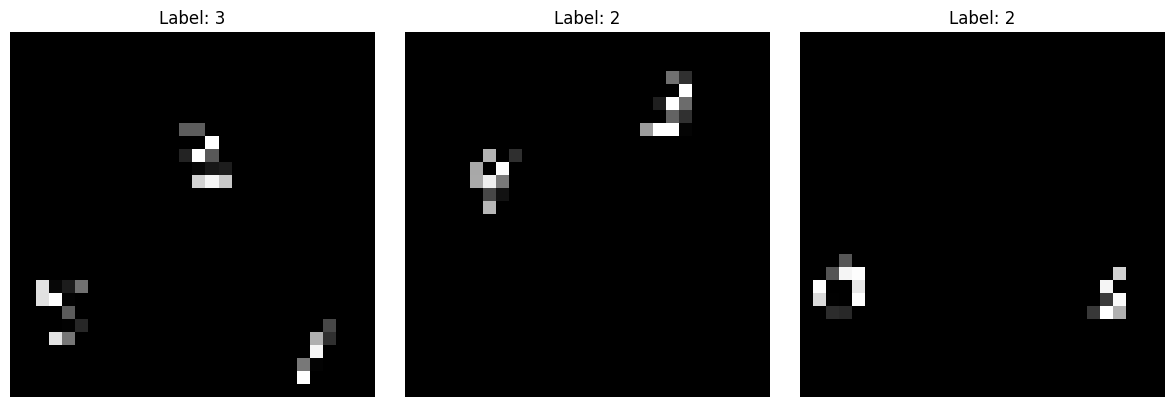

In [25]:
# Get a batch of images and labels from the train_loader
images, labels = next(iter(train_loader))

# Select the first three images and labels
images_to_plot = images[:3]
labels_to_plot = labels[:3]

# Plotting the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, img, label in zip(axes, images_to_plot, labels_to_plot):
    ax.imshow(img.squeeze(), cmap='gray')  # Remove the channel dimension for grayscale
    ax.set_title(f'Label: {label.item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Epoch [1/10], Training Loss: 2.6132, Training Metric: 0.8645
Epoch [2/10], Training Loss: 0.0802, Training Metric: 0.9717
Epoch [3/10], Training Loss: 0.0769, Training Metric: 0.9763
Epoch [4/10], Training Loss: 0.0744, Training Metric: 0.9789
Epoch [5/10], Training Loss: 0.0657, Training Metric: 0.9796
Epoch [6/10], Training Loss: 0.0537, Training Metric: 0.9859
Epoch [7/10], Training Loss: 0.0924, Training Metric: 0.9793
Epoch [8/10], Training Loss: 0.0566, Training Metric: 0.9833
Epoch [9/10], Training Loss: 0.0765, Training Metric: 0.9781
Epoch [10/10], Training Loss: 0.0791, Training Metric: 0.9794


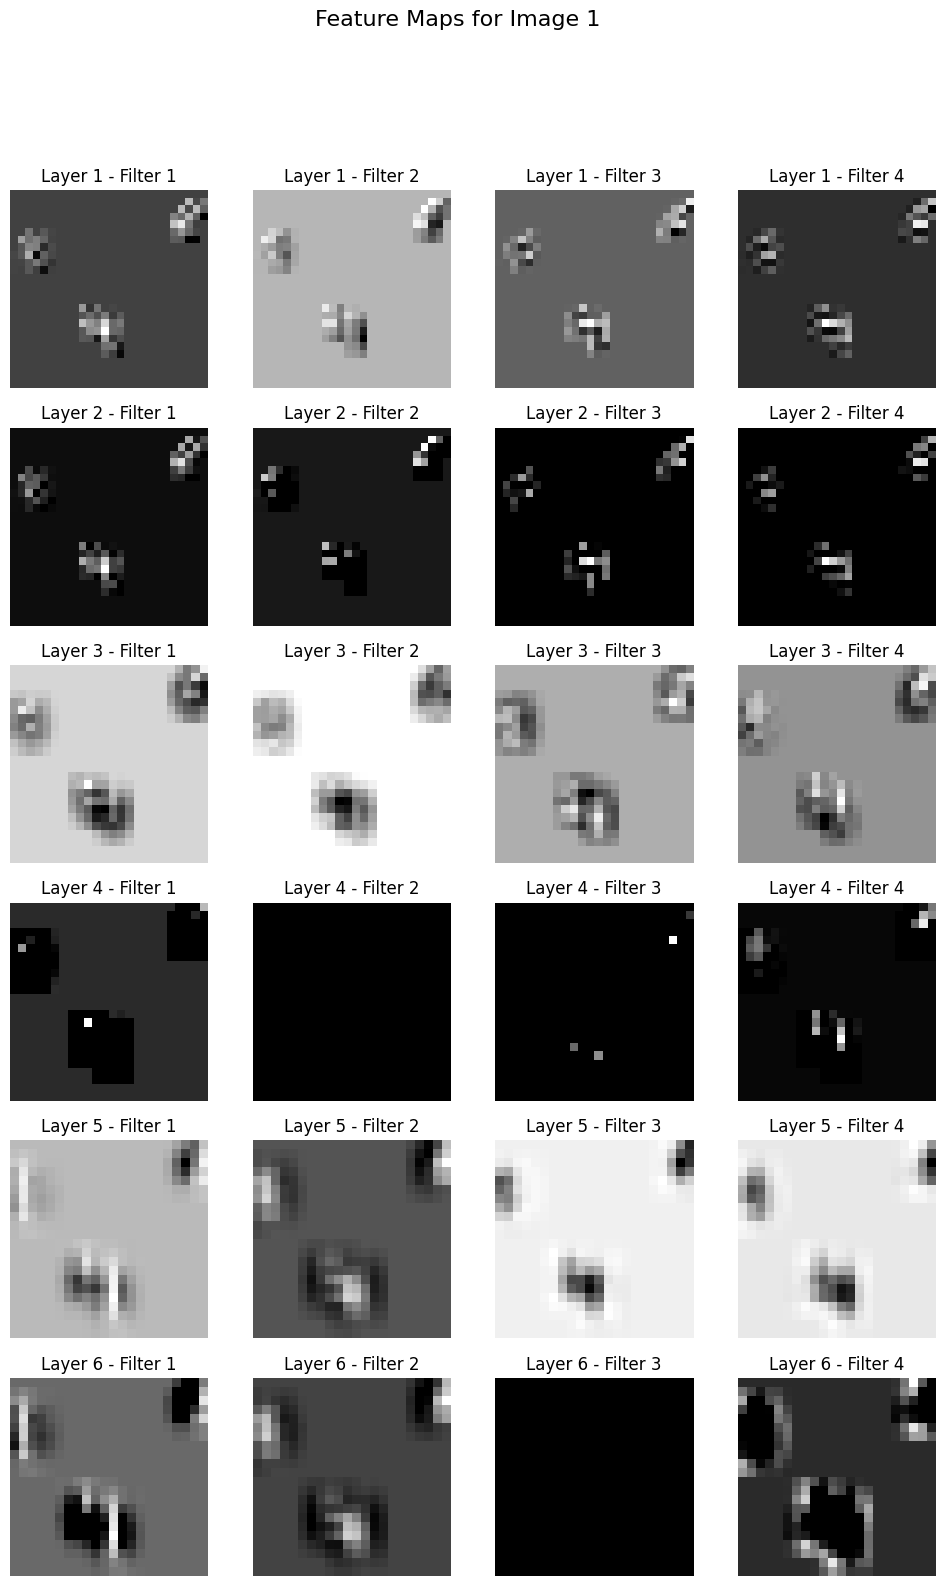

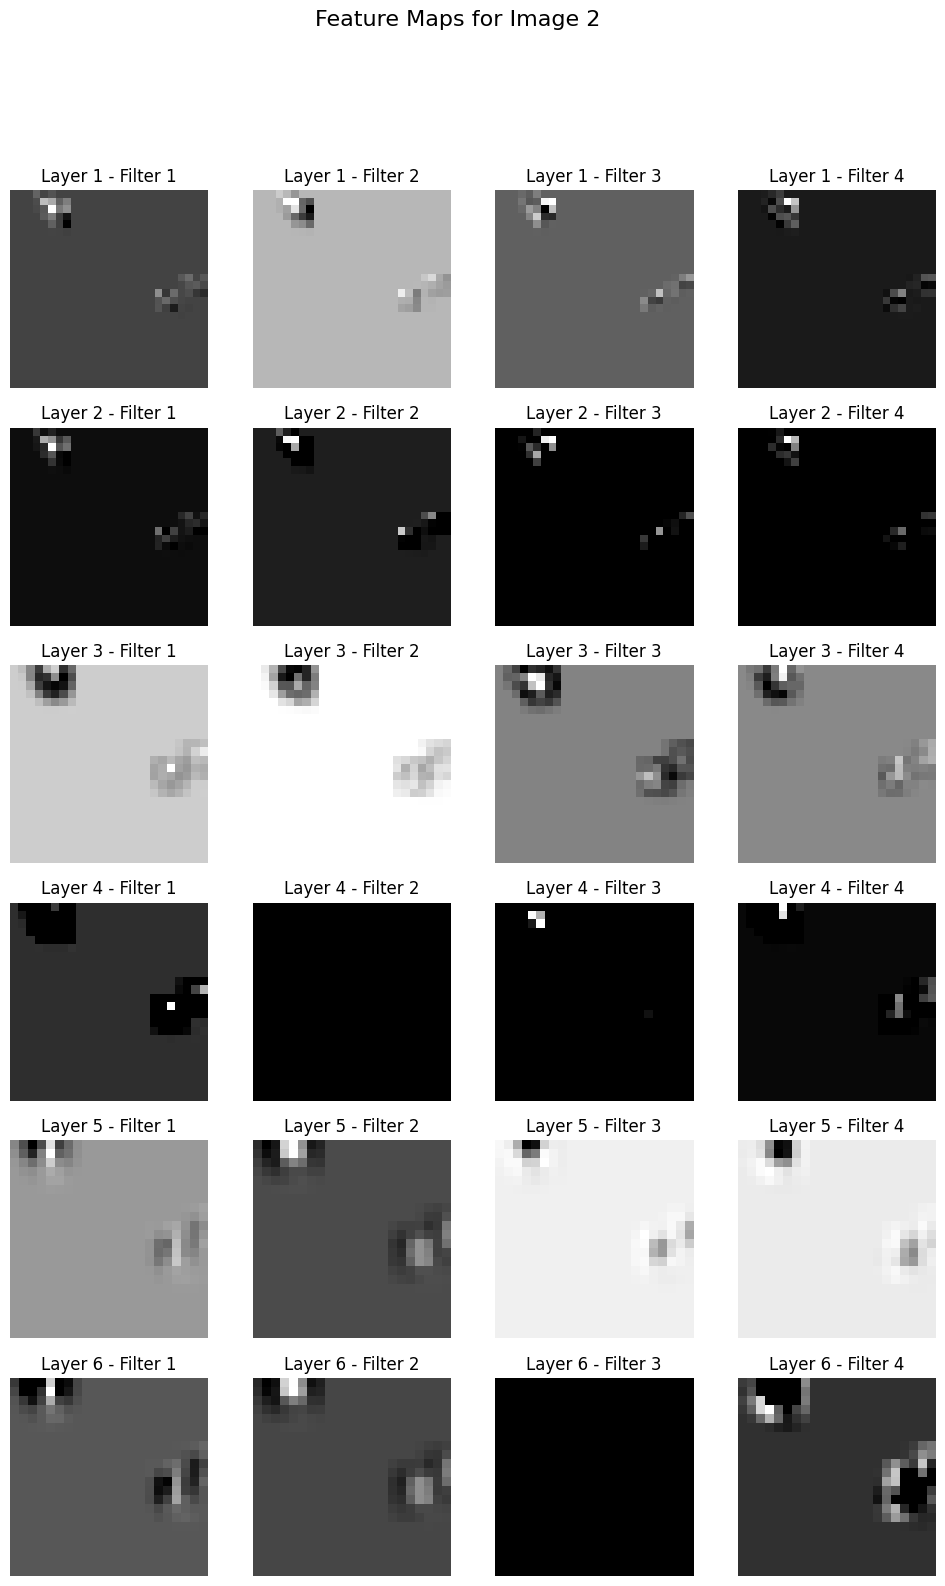

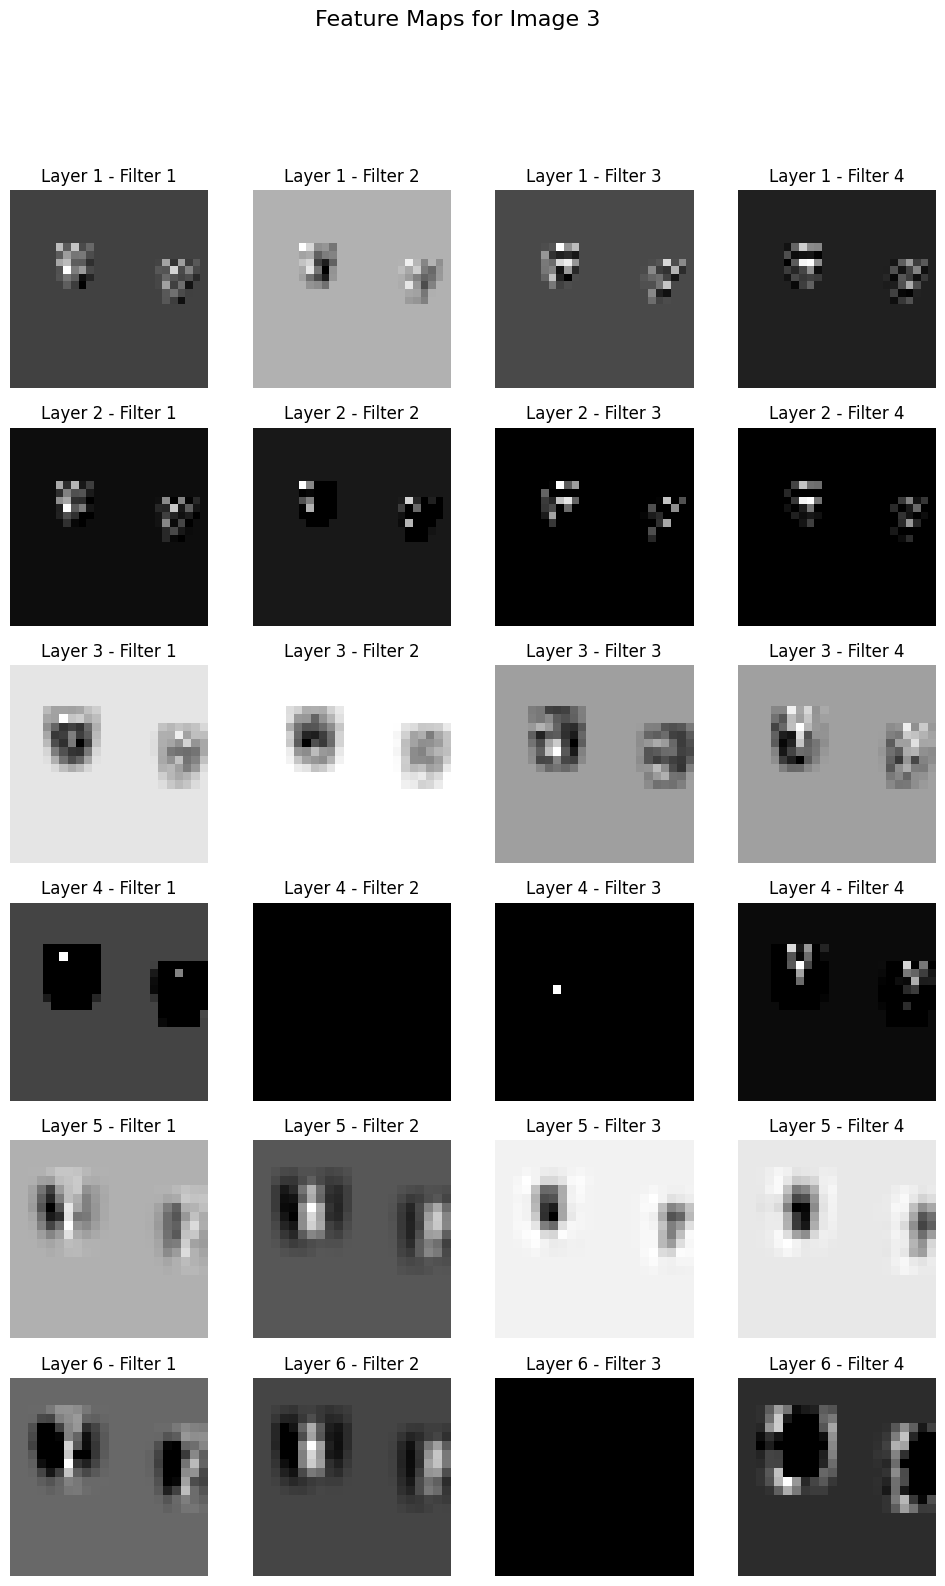

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = 'classification'
# dropout_rate = 0.5
# conv_layers = [32, 64, 128]

model2 = CNN(task=task_type, dropout_rate=dropout_rate, conv_layers=conv_layers).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_model(model2, train_loader, criterion, optimizer, task_type, device)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Metric: {train_accuracy:.4f}")


sample_images, _ = next(iter(train_loader))  
images_to_visualize = sample_images[:3]     

visualize_feature_maps(model2, images_to_visualize, device)

### Observations:

Layer 1:

The filters in the first layer seem to focus on very basic visual information, such as edges and gradients. The feature maps display high contrast around specific regions, indicating that the network is identifying simple, low-level features like edges or changes in brightness.

Layer 2:

In the second layer, the feature maps become darker and less distinct, likely because they are combining information from the edges and gradients detected in the first layer. This layer might be capturing slightly more complex patterns, such as simple shapes or blobs, but still remains at a low level of abstraction.

Layer 3:

By the third layer, the feature maps show more blurred and abstract patterns. The filters may be focusing on combinations of edges or simple textures, building upon the basic features learned in the first two layers. This could represent an attempt by the network to capture slightly higher-level features, such as patterns or shapes in different regions of the image.

Layers 4-6:

In these deeper layers, the feature maps show sparse activation, with only a few regions highlighted, and often appear quite dark overall. This suggests that these layers are learning more specific, high-level features that may only activate for certain patterns or objects present in the image. These could represent parts of specific objects or complex textures, learned by combining features from previous layers.

### Summary of Features:

Early Layers (1-2): Low-level features like edges, textures, and brightness variations.

Mid Layers (3): Combinations of edges and textures, leading to more abstract shapes and patterns.

Deeper Layers (4-6): High-level features, focusing on specific regions or structures, which could be indicative of parts of objects or distinct patterns relevant to the model’s objective.


Multi Label Classification

## MultiLabelCNN
The MultiLabelCNN class requires an additional activation function after the last linear layer, specifically the sigmoid activation function. This is essential for multi-label classification tasks where multiple classes can be activated independently for a single input.
### Justification for Using Sigmoid Activation

    Independent Class Predictions: In multi-label classification, each class's output is independent, allowing for multiple labels to be activated simultaneously.

    Probability Mapping: The sigmoid function maps the output to a range between 0 and 1, providing a probability for each class. This allows the model to determine the presence of each class independently.

    Flexibility in Class Activation: Applying a threshold (e.g., 0.5) on the sigmoid outputs enables the model to classify instances into multiple classes based on their probabilities, which is crucial for multi-label tasks.

In summary, the use of the sigmoid function in the MultiLabelCNN is necessary to handle the independent nature of class outputs in multi-label classification effectively.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
np.random.seed(42)

In [2]:
def load_mnist_data_multi_label(data_dir):
    splits = ['train', 'val', 'test']
    data = {}

    for split in splits:
        images = []
        labels = []
        split_dir = os.path.join(data_dir, split)

        for folder_name in os.listdir(split_dir):
            folder_path = os.path.join(split_dir, folder_name)
            if not os.path.isdir(folder_path):
                continue

            # Multi-hot encode the label based on the subfolder name
            label = np.zeros((3, 11), dtype=int)
            if folder_name != '0':
                length = len(folder_name)
                for i, digit_char in enumerate(folder_name):
                    label[i, int(digit_char)] = 1
                    label[i, 10] = 1
            # label = np.zeros(10, dtype=int) # Multi-hot encoded vector for digits 0-9
            # for digit in folder_name:
            #     label[int(digit)] = 1

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (28, 28))
                images.append(img)
                labels.append(label)

        data[f"{split}_images"] = np.array(images, dtype=np.float32)
        data[f"{split}_labels"] = np.array(labels, dtype=np.int64)

    return data['train_images'], data['train_labels'], data['val_images'], data['val_labels'], data['test_images'], data['test_labels']

In [3]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = image / 255.0

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32) # Multi-hot encoded label as float

        return image, label

In [4]:
data_dir = "/kaggle/input/double-mnist/double_mnist"

train_images, train_labels, val_images, val_labels, test_images, test_labels = load_mnist_data_multi_label(data_dir)

train_dataset = MultiMNISTDataset(train_images, train_labels)
val_dataset = MultiMNISTDataset(val_images, val_labels)
test_dataset = MultiMNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelCNN(nn.Module):
    def __init__(self, conv_layers_config = [32, 64, 128], kernel_size = 3, stride = 1, dropout_rate = 0.25, padding = 1, num_classes=3*11):
        super(MultiLabelCNN, self).__init__()

        self.conv_layers = nn.ModuleList()
        
        # Create convolutional layers based on config
        in_channels = 1  # Grayscale input
        for out_channels in conv_layers_config:
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            in_channels = out_channels

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Calculate the number of features for the fully connected layer
        self._initialize_fc_in_features(conv_layers_config)

        # Define fully connected layers
        self.fc1 = nn.Linear(self.in_features, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _initialize_fc_in_features(self, conv_layers_config):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            x = dummy_input
            for conv_layer in self.conv_layers:
                x = self.pool(F.relu(conv_layer(x)))
            self.in_features = x.numel()

    def forward(self, x):
        # Pass through each convolutional layer with activation and pooling
        for conv_layer in self.conv_layers:
            x = F.relu(conv_layer(x))
            x = self.pool(x)
        
        # Flatten
        x = x.view(-1, self.in_features)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Final output layer with sigmoid for multi-label classification
        x = self.fc2(x)
        return torch.sigmoid(x).view(-1, 3, 11) # Reshape to 3x11 for multi-label classification


In [6]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, hamming_loss

def train_model(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_loss

def evaluate_model(model, val_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Flatten arrays to (batch_size, 33) for Hamming loss calculation
    all_preds_flat = all_preds.reshape(-1, 33)
    all_labels_flat = all_labels.reshape(-1, 33)
    
    epoch_loss = running_loss / len(val_loader.dataset)
    exact_match_acc = np.mean(np.all(all_preds == all_labels, axis=1))
    # exact_match_acc = (all_preds == all_labels).all(dim=1).float().mean().item()
    hamming_loss_score = hamming_loss(all_labels_flat, all_preds_flat)
    hamming_acc = 1 - hamming_loss_score

    return epoch_loss, exact_match_acc, hamming_acc

In [17]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = MultiLabelCNN(conv_layers_config=[32, 64, 128, 256]).to(device)

# Set criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation data loaders (assume these are created as shown previously)
train_loader = train_loader  # Replace with actual DataLoader
val_loader = val_loader      # Replace with actual DataLoader

# Training parameters
num_epochs = 10
for epoch in range(num_epochs):
    # Train the model
    train_loss = train_model(model, train_loader, criterion, optimizer, device=device)

    # Evaluate the model
    val_loss, exact_match_acc, hamming_acc = evaluate_model(model, val_loader, criterion, device=device)

    # Print epoch metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Exact Match Accuracy: {exact_match_acc:.4f}, Hamming Accuracy: {hamming_acc:.4f}")

Epoch [1/10], Train Loss: 0.2792, Val Loss: 0.2483, Exact Match Accuracy: 0.7861, Hamming Accuracy: 0.9232
Epoch [2/10], Train Loss: 0.2137, Val Loss: 0.2176, Exact Match Accuracy: 0.8272, Hamming Accuracy: 0.9379
Epoch [3/10], Train Loss: 0.1968, Val Loss: 0.2158, Exact Match Accuracy: 0.8278, Hamming Accuracy: 0.9381
Epoch [4/10], Train Loss: 0.1882, Val Loss: 0.2117, Exact Match Accuracy: 0.8308, Hamming Accuracy: 0.9391
Epoch [5/10], Train Loss: 0.1790, Val Loss: 0.2101, Exact Match Accuracy: 0.8331, Hamming Accuracy: 0.9399
Epoch [6/10], Train Loss: 0.1716, Val Loss: 0.2034, Exact Match Accuracy: 0.8332, Hamming Accuracy: 0.9399
Epoch [7/10], Train Loss: 0.1674, Val Loss: 0.1993, Exact Match Accuracy: 0.8349, Hamming Accuracy: 0.9405
Epoch [8/10], Train Loss: 0.1626, Val Loss: 0.2029, Exact Match Accuracy: 0.8341, Hamming Accuracy: 0.9402
Epoch [9/10], Train Loss: 0.1600, Val Loss: 0.1990, Exact Match Accuracy: 0.8363, Hamming Accuracy: 0.9411
Epoch [10/10], Train Loss: 0.1570, Va

In [51]:
import wandb


In [55]:
def hyperparameter_tuning_sweep(train_loader, val_loader, device='cpu'):
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'exact_match_accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'conv_configs': {
                'values': [
                          [32, 64],             # Two layers
                          [32, 64, 128],        # Three layers
                          [32, 64, 128, 256]    # Four layers
                          ]
            },
            'learning_rate': {
                'values': [0.001, 0.1]
            },
            'dropout_rate': {
                'values': [0.2, 0.5]
            },
            'epochs': {
                'values': [10, 50]
            },
            'optimizer': {
                'values': ['adam', 'sgd']
            },
        }
    }

    sweep_id = wandb.sweep(sweep_config, project="CNN-MultiLabel-Hyperparameter-Tuning")

    def train_and_evaluate():
        wandb.init()
        config = wandb.config
        print(f"Running with config: {config}")
        wandb.run.name = f"conv_layers={config['conv_configs']}-optimizer={config['optimizer']}-lr={config['learning_rate']}-epochs={config['epochs']}-dropout={config['dropout_rate']}"

        model = MultiLabelCNN(conv_layers_config=config['conv_configs'], dropout_rate=config['dropout_rate']).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate']) if config['optimizer'] == 'adam' else optim.SGD(model.parameters(), lr=config['learning_rate'])

        criterion = nn.BCELoss()

        train_losses, val_losses, exact_match_accuracies, hamming_accuracies = [], [], [], []

        for epoch in range(config['epochs']):
            # model.train()
            train_loss = train_model(model, train_loader, criterion, optimizer, device=device)
            train_losses.append(train_loss)

            # model.eval()
            val_loss, exact_match_acc, hamming_acc = evaluate_model(model, val_loader, criterion, device=device)
            val_losses.append(val_loss)
            exact_match_accuracies.append(exact_match_acc)
            hamming_accuracies.append(hamming_acc)

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                })
        wandb.log({"exact_match_accuracy": exact_match_acc,
                "hamming_accuracy": hamming_acc,})
        wandb.finish()

    wandb.agent(sweep_id, function=train_and_evaluate)
hyperparameter_tuning_sweep(train_loader, val_loader, device=device)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 6qthfrk9
Sweep URL: https://wandb.ai/vcnk4v/CNN-MultiLabel-Hyperparameter-Tuning/sweeps/6qthfrk9


wandb: Agent Starting Run: qd8u4mxv with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


wandb: 🚀 View run graceful-sweep-5 at: https://wandb.ai/vcnk4v/CNN-MultiLabel-Hyperparameter-Tuning/runs/aajxowuj
wandb: Find logs at: wandb/run-20241102_211738-aajxowuj/logs


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▄▄▃▃▂▂▂▁▁
val_loss,█▇█▆▇▄▄▆▂▁
epoch,10
exact_match_accuracy,0.83633
hamming_accuracy,0.94021
train_loss,0.16232
val_loss,0.19264


wandb: Agent Starting Run: 0qo2lc66 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▇▆▆▅▄▃▃▂▁
val_loss,█▇▆▆▅▄▄▃▂▁
epoch,10
exact_match_accuracy,0.48779
hamming_accuracy,0.78485
train_loss,0.6706
val_loss,0.66897


wandb: Agent Starting Run: pnk3js4y with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁█████████
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: 2ie24axv with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▆█▇▅▅▅▃▃▂▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.25264
val_loss,0.25573


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hzu1i57w with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▅▅▅▅▅▄▄▄▃▄▃▂▃▂▂▁▁▂▁▁▁▂▂▂▂▃▃▃▃▃▄▅▅▅▅▆▆▇▇█
epoch,50
exact_match_accuracy,0.83385
hamming_accuracy,0.94061
train_loss,0.08069
val_loss,0.24284


wandb: Agent Starting Run: d077skbi with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,████████▇▇▇▇▆▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████████▇▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.26159
val_loss,0.25976


wandb: Agent Starting Run: gf9fv0il with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁███████████████████████████████████████
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: ieon0hwk with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███████████▇▇▇▇▅▄▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.82621
hamming_accuracy,0.93762
train_loss,0.19366
val_loss,0.2103


wandb: Agent Starting Run: 1ya9xku1 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▄▃▃▂▂▁▁▁▁
val_loss,█▄▄▄▃▁▂▂▂▃
epoch,10
exact_match_accuracy,0.83679
hamming_accuracy,0.94113
train_loss,0.17849
val_loss,0.20819


wandb: Agent Starting Run: t82qjvix with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,██▇▇▆▅▅▄▂▁
val_loss,██▇▇▆▆▅▄▃▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.61579
val_loss,0.60616


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fqim6h3d with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁█████████
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.60245
val_loss,7.67677


wandb: Agent Starting Run: 6sdt4ddx with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▂▂▁▁▁▁▁▁▁
val_loss,█▅▇▇▅▆▄▅▄▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.25616
val_loss,0.25603


wandb: Agent Starting Run: 8ipxcujy with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▇▆▅▅▄▄▅▃▄▄▄▃▂▂▂▃▁▂▁▁▂▁▂▁▂▁▁▂▂▂▄▂▂▂▂▂▃
epoch,50
exact_match_accuracy,0.84424
hamming_accuracy,0.94347
train_loss,0.1328
val_loss,0.19625


wandb: Agent Starting Run: mqrep454 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█████▇▇▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██████▇▇▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.27533
val_loss,0.2597


wandb: Agent Starting Run: elbdxkww with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁███████████████████████████████████████
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: o8tzymu5 with config:
wandb: 	conv_configs: [32, 64]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▄▄▄▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████████▇▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.82645
hamming_accuracy,0.9377
train_loss,0.19696
val_loss,0.21073


wandb: Agent Starting Run: kfag4ixx with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▅▅▆▄▄▃▂▂▁
epoch,10
exact_match_accuracy,0.83715
hamming_accuracy,0.94104
train_loss,0.16667
val_loss,0.19153


wandb: Agent Starting Run: 4tuw6c93 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▇▇▆▅▄▃▃▂▁
val_loss,█▇▇▆▅▄▃▃▂▁
epoch,10
exact_match_accuracy,0.34761
hamming_accuracy,0.75312
train_loss,0.67358
val_loss,0.67287


wandb: Agent Starting Run: xswwxfwv with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁█████████
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: fzcjjca2 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▄██▇▅▁▄▇▄▃
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.25391
val_loss,0.25765


wandb: Agent Starting Run: 261dgygq with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▆▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄
epoch,50
exact_match_accuracy,0.85603
hamming_accuracy,0.94851
train_loss,0.08738
val_loss,0.19643


wandb: Agent Starting Run: sr0xp4u0 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,██████████▇▇▇▇▇▇▆▆▅▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██████████▇▇▇▇▇▆▆▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.26293
val_loss,0.26024


wandb: Agent Starting Run: a1k5e8rj with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁███████████████████████████████████████
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: bnappmp6 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████████▇▇▇▇▇▇▇▇▇▇▆▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁
epoch,50
exact_match_accuracy,0.82682
hamming_accuracy,0.93783
train_loss,0.1931
val_loss,0.21125


wandb: Agent Starting Run: da3osiap with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_loss,█▂▁▃▂▂▁▁▂▂
epoch,10
exact_match_accuracy,0.83182
hamming_accuracy,0.93949
train_loss,0.17736
val_loss,0.21544


wandb: Agent Starting Run: c82l7b26 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▇▇▆▅▄▄▃▂▁
val_loss,█▇▇▆▅▄▄▃▂▁
epoch,10
exact_match_accuracy,0.28358
hamming_accuracy,0.69848
train_loss,0.67525
val_loss,0.67454


wandb: Agent Starting Run: f27spogl with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁█████████
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: qay3aahi with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▄▄▃▁▂▂▃
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.25735
val_loss,0.25786


wandb: Agent Starting Run: 05yc3r9s with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▆▅▅▄▄▄▃▄▄▃▃▃▃▃▃▁▂▂▂▂▁▁▂▂▂▂▂▃▃▃▂▂▃▄▄▄▄
epoch,50
exact_match_accuracy,0.85173
hamming_accuracy,0.94607
train_loss,0.12263
val_loss,0.20003


wandb: Agent Starting Run: gvk6mmh9 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,███████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▅▅▄▃▂▁▁▁▁
val_loss,████████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▅▄▄▃▂▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.28867
val_loss,0.26


wandb: Agent Starting Run: 4cwkdc7c with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁███████████████████████████████████████
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: j2yw3337 with config:
wandb: 	conv_configs: [32, 64, 128]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███████████▇▇█▇▇▇▆▅▅▄▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▂▂▁▁
epoch,50
exact_match_accuracy,0.82673
hamming_accuracy,0.9378
train_loss,0.19657
val_loss,0.20912


wandb: Agent Starting Run: 50wgydot with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▄▃▃▂▂▂▁▁▁
val_loss,█▄▅▆▂▄▂▂▃▁
epoch,10
exact_match_accuracy,0.8377
hamming_accuracy,0.94108
train_loss,0.1607
val_loss,0.18945


wandb: Agent Starting Run: lx4ab780 with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▇▆▆▅▄▃▃▂▁
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
exact_match_accuracy,0.19239
hamming_accuracy,0.61555
train_loss,0.68161
val_loss,0.68137


wandb: Agent Starting Run: 1ze33m0o with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁█████████
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: v5o7hxdy with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▂▃▂▁▁▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.254
val_loss,0.25754


wandb: Agent Starting Run: 27jrf7mx with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,▆▄▄▃▃▄▃▃▃▂▃▃▃▂▄▂▃▂▃▂▁▄▃▂▃▃▂▄▃▃▄▄▅▄▅▆▆██▇
epoch,50
exact_match_accuracy,0.83224
hamming_accuracy,0.9402
train_loss,0.05998
val_loss,0.25817


wandb: Agent Starting Run: ikdr2rds with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█████▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▁
val_loss,████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.61183
val_loss,0.60946


wandb: Agent Starting Run: gvs4xnbi with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁███████████████████████████████████████
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: j2axbibc with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁
val_loss,████████▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▅▄▃▂▂▃▂▂▁▁▁▁▁
epoch,50
exact_match_accuracy,0.82664
hamming_accuracy,0.93777
train_loss,0.19741
val_loss,0.21262


wandb: Agent Starting Run: ffewpxhl with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_loss,█▂▃▂▄▃▂▁▃▁
epoch,10
exact_match_accuracy,0.83424
hamming_accuracy,0.94034
train_loss,0.17589
val_loss,0.21125


wandb: Agent Starting Run: c7mq6h36 with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▇▆▆▅▄▃▃▂▁
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
exact_match_accuracy,0.33682
hamming_accuracy,0.72115
train_loss,0.67647
val_loss,0.67608


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wfipphuc with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁█████████
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: i06zdr86 with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▅▃▃▂▂▁▂
epoch,10
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.25669
val_loss,0.25758


wandb: Agent Starting Run: cco79at5 with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▄▅▄▅▃▃▂▃▁▃▂▃▂▂▁▂▂▂▂▂▂▂▂▃▁▂▄▂▃▂▃▄▂▃▅▄▄▄▅
epoch,50
exact_match_accuracy,0.84542
hamming_accuracy,0.94425
train_loss,0.11069
val_loss,0.23073


wandb: Agent Starting Run: fea12r2b with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▄▄▃▁
val_loss,███████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▄▄▃▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,0.39771
val_loss,0.36473


wandb: Agent Starting Run: mat4xc7o with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'adam'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,▁███████████████████████████████████████
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.78606
hamming_accuracy,0.92323
train_loss,7.59981
val_loss,7.67677


wandb: Agent Starting Run: daeuh3lj with config:
wandb: 	conv_configs: [32, 64, 128, 256]
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	optimizer: sgd


Running with config: {'conv_configs': [32, 64, 128, 256], 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.1, 'optimizer': 'sgd'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
exact_match_accuracy,▁
hamming_accuracy,▁
train_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,███████████████████▇▇▇▇▇▇▇▆▆▆▄▃▂▂▂▁▁▁▁▁▁
epoch,50
exact_match_accuracy,0.82673
hamming_accuracy,0.9378
train_loss,0.2032
val_loss,0.21355


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7a3584fd42e0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7a356425db40, execution_count=55 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7a356425e620, raw_cell="def hyperparameter_tuning_sweep(train_loader, val_.." store_history=True silent=False shell_futures=True cell_id=51a37e2f-b42e-4caf-a0b8-bff51cd91a41> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
| conv_configs      | dropout_rate | learning_rate | optimizer | exact_match_accuracy | hamming_accuracy | train_loss         | val_loss           |
|-------------------|--------------|---------------|-----------|-----------------------|------------------|---------------------|--------------------|
| [32,64,128]       | 0.5          | 0.001         | adam      | 0.8538               | 0.9471           | 0.1254             | 0.1926            |
| [32,64]           | 0.5          | 0.001         | adam      | 0.8459               | 0.9440           | 0.1244             | 0.1971            |
| [32,64,128]       | 0.2          | 0.001         | adam      | 0.8448               | 0.9440           | 0.0925             | 0.1922            |
| [32,64,128,256]   | 0.5          | 0.001         | adam      | 0.8397               | 0.9423           | 0.1239             | 0.2313            |
| [32,64]           | 0.2          | 0.001         | adam      | 0.8385               | 0.9420           | 0.0717             | 0.2447            |


In [9]:
best_model = {
            'conv_configs': [32, 64, 128],
            'learning_rate': 0.001,
            'dropout_rate': 0.5,
            'epochs': 50,
            'optimizer': 'adam',
        }

# Instantiate model
best_model_multi = MultiLabelCNN(conv_layers_config=best_model['conv_configs'], dropout_rate=best_model['dropout_rate']).to(device)

# Set criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model_multi.parameters(), lr=best_model['learning_rate'])

# Training and validation data loaders (assume these are created as shown previously)
train_loader = train_loader  # Replace with actual DataLoader
val_loader = val_loader      # Replace with actual DataLoader

# Training parameters
num_epochs = best_model['epochs']
for epoch in range(num_epochs):
    # Train the model
    train_loss = train_model(best_model_multi, train_loader, criterion, optimizer, device=device)

    # Evaluate the model
    val_loss, val_exact_match_acc, val_hamming_acc = evaluate_model(best_model_multi, val_loader, criterion, device=device)
    test_loss, test_exact_match_acc, test_hamming_acc = evaluate_model(best_model_multi, test_loader, criterion, device=device)

    # Print epoch metrics
    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"\n\t\tVal Exact Match Accuracy: {val_exact_match_acc:.4f}, Val Hamming Accuracy: {val_hamming_acc:.4f}, "
             f"\n\t\tTest Exact Match Accuracy: {test_exact_match_acc:.4f}, Test Hamming Accuracy: {test_hamming_acc:.4f}")

Epoch [1/50]: Train Loss: 0.2815, Val Loss: 0.2293, 
		Val Exact Match Accuracy: 0.8124, Val Hamming Accuracy: 0.9330, 
		Test Exact Match Accuracy: 0.8130, Test Hamming Accuracy: 0.9346
Epoch [2/50]: Train Loss: 0.2186, Val Loss: 0.2156, 
		Val Exact Match Accuracy: 0.8275, Val Hamming Accuracy: 0.9380, 
		Test Exact Match Accuracy: 0.8395, Test Hamming Accuracy: 0.9435
Epoch [3/50]: Train Loss: 0.2036, Val Loss: 0.2202, 
		Val Exact Match Accuracy: 0.8276, Val Hamming Accuracy: 0.9381, 
		Test Exact Match Accuracy: 0.8408, Test Hamming Accuracy: 0.9439
Epoch [4/50]: Train Loss: 0.1983, Val Loss: 0.2173, 
		Val Exact Match Accuracy: 0.8276, Val Hamming Accuracy: 0.9381, 
		Test Exact Match Accuracy: 0.8408, Test Hamming Accuracy: 0.9439
Epoch [5/50]: Train Loss: 0.1936, Val Loss: 0.2152, 
		Val Exact Match Accuracy: 0.8280, Val Hamming Accuracy: 0.9382, 
		Test Exact Match Accuracy: 0.8410, Test Hamming Accuracy: 0.9439
Epoch [6/50]: Train Loss: 0.1884, Val Loss: 0.2139, 
		Val Exact 

		Val Exact Match Accuracy: 0.8539, Val Hamming Accuracy: 0.9469, 
		Test Exact Match Accuracy: 0.8554, Test Hamming Accuracy: 0.9493

In [12]:
train_loss, train_exact_match_acc, train_hamming_acc = evaluate_model(best_model_multi, train_loader, criterion, device=device)
print(train_loss, train_exact_match_acc, train_hamming_acc)

0.09833536188753825 0.8766955266955268 0.9568734968734969


def evaluate_model(model, val_loader, criterion, task_type, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    all_preds = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs, _ = model(images)
            if task_type == "regression":
                outputs = outputs.squeeze(-1)
        
            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Track predictions
            all_preds.extend(outputs.detach().cpu().numpy())  # Store predictions

    # Calculate average loss
    avg_loss = running_loss / len(val_loader)
    
    return avg_loss, np.array(all_preds)  # Return predictions as well
train_loss, train_exact_match_acc, train_hamming_acc = 0.09833536188753825 0.8766955266955268 0.9568734968734969